In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import widgets, Layout
from IPython.display import display
from nipype.interfaces.nipy import SpaceTimeRealigner, ComputeMask
from nipype.interfaces.fsl import BET, MeanImage, ApplyMask, SwapDimensions
from nipype.interfaces.afni import SkullStrip, Automask
import seaborn as sns
from nipype.interfaces.ants import N4BiasFieldCorrection, Registration
from pca_utils import pca_denoising

In [3]:
in_dir = '/home/julia/projects/lc/20181006_165517_JH_LC_rsfMRI_03_1_1_nifti/JHLCrsfMRI/'
out_dir = '/home/julia/projects/lc/JH_LC_rsfMRI_03_analysis/'
wholebrain_file = out_dir + 'struct/struct_masked.nii.gz'
slab_file = in_dir + 'JHLCrsfMRI_24/JHLCrsfMRI_24.nii.gz'
slab_data = nb.load(slab_file).get_data()
slab_aff = nb.load(slab_file).affine
slab_hdr = nb.load(slab_file).header

In [6]:
if not os.path.isdir(out_dir+'struct/single_vols'):
    if not os.path.isdir(out_dir+'struct/'):
        if not os.path.isdir(out_dir):
            os.mkdir(out_dir)
        os.mkdir(out_dir+'struct/')
    os.mkdir(out_dir+'struct/single_vols')

### Structural data: denoising, bias field correction, average, mask

In [9]:
mp_slab_data, mp_slab_sigmas, mp_slab_components = pca_denoising(slab_data)
nb.save(nb.Nifti1Image(mp_slab_data, slab_aff, slab_hdr), out_dir+'struct/slab_mp_data.nii.gz')
nb.save(nb.Nifti1Image(mp_slab_sigmas, slab_aff, slab_hdr), out_dir+'struct/slab_mp_sigmas.nii.gz')
nb.save(nb.Nifti1Image(mp_slab_components, slab_aff, slab_hdr), out_dir+'struct/slab_mp_components.nii.gz')

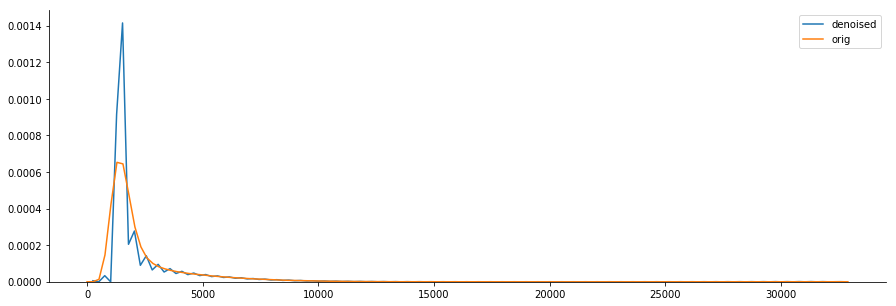

In [12]:
fig=plt.figure(figsize=(15,5))
sns.kdeplot(mp_slab_data.flatten(), label='denoised')
sns.kdeplot(slab_data.flatten(), label='orig')
plt.legend()
sns.despine()

In [14]:
for i in range(mp_slab_data.shape[3]):
    nb.save(nb.Nifti1Image(mp_slab_data[:,:,:,i], slab_aff, slab_hdr),
            out_dir + 'struct/single_vols/slab_vol%s.nii.gz'%i)
    n4 = N4BiasFieldCorrection(input_image=out_dir + 'struct/single_vols/slab_vol%s.nii.gz'%i, dimension=3,
                               n_iterations=[100,100,100,100], convergence_threshold=0.0,
                               output_image= out_dir + 'struct/single_vols/slab_vol%s_corrected.nii.gz'%i)
    n4.run()

In [15]:
corrected_data = []
for i in range(mp_slab_data.shape[3]):
    corrected_data.append(nb.load(out_dir + 'struct/single_vols/slab_vol%s_corrected.nii.gz'%i).get_data())

nb.save(nb.Nifti1Image(np.average(corrected_data[:], axis=0), slab_aff, slab_hdr),
        out_dir + 'struct/slab_avg_corrected.nii.gz')

In [26]:
slab_lin = nb.load(out_dir + 'struct/slab2struct_landmark.nii.gz').get_data()
slab_lin_aff = nb.load(out_dir + 'struct/slab2struct_landmark.nii.gz').affine
slab_lin_hdr = nb.load(out_dir + 'struct/slab2struct_landmark.nii.gz').header
slab_lin[np.where(slab_nonlin<628)]=0
nb.save(nb.Nifti1Image(slab_lin, slab_lin_aff, slab_lin_hdr),
        out_dir + 'struct/slab2struct_landmark_masked.nii.gz')